In [22]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_target_sample

In [23]:
target = load_target_sample()
target.head()

,Season,team_a,team_b,in_target
ID,,,,
2014_1107_1110,2014,1107,1110,True
2014_1107_1112,2014,1107,1112,True
2014_1107_1113,2014,1107,1113,True
2014_1107_1124,2014,1107,1124,True
2014_1107_1140,2014,1107,1140,True


In [25]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
800,1997,139,1344,98,1181,87,N,0,11


In [117]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
print(regular_games.shape)
regular_games.sample()

(150684, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
122731,2012,103,1411,72,1212,54,H,0,18


In [118]:
# data = pd.concat([ncaa_games, regular_games])
data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 3
for team, opponent_team in [('a', 'b'), ('b','a')]:
    pass 
    
data = data.dropna()
data.head(5)

,Season,a_win,in_target,team_a,team_b
0,1985,True,False,1116,1234
1,1985,True,False,1120,1345
2,1985,True,False,1207,1250
3,1985,True,False,1229,1425
4,1985,True,False,1242,1325


In [119]:
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder


libfm_feature_cols = ['Season', 'team_a', 'team_b']
X = data[~data.in_target.astype(bool)][libfm_feature_cols]
X_enc = OneHotEncoder().fit_transform(X)
y = data[~data.in_target.astype(bool)][['a_win']].values.reshape(-1)

path = 'data/libfm/cv_{}-{:d}-of-3-shuffle.{}'
kf = KFold(n_splits=3, shuffle=True)
metrics = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    with open(path.format("train", i, "libfm"),'wb') as f:
        dump_svmlight_file(X_enc[train_index], y[train_index], f)
        
    with open(path.format("test", i, "libfm"),'wb') as f:
        dump_svmlight_file(X_enc[test_index], 0.5*np.ones(X_enc[test_index].shape[0]), f)
        
    !dist/libfm/bin/LibFM\
        -task c\
        -test data/libfm/cv_test-{i}-of-3-shuffle.libfm\
        -train data/libfm/cv_train-{i}-of-3-shuffle.libfm \
        -verbosity 0\
        -out data/libfm/predictions.csv\
        -iter 50\
        -init_stdev .5
        
    preds = np.loadtxt('data/libfm/predictions.csv')
    metric = log_loss(y[test_index], preds)
    metrics.append(metric)
    
!ls data/libfm/
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=101867	num_values=305601	num_features=754	min_target=0	max_target=1
Loading test... 	
has x = 0
has xt = 1
num_rows=50934	num_values=152802	num_features=754	min_target=0.5	max_target=0.5
#relations: 0
Loading meta data...	
#Iter=  0	Train=0.611277	Test=0.504319	Test(ll)=0.333417
#Iter=  1	Train=0.648709	Test=0.497978	Test(ll)=0.331049
#Iter=  2	Train=0.659546	Test=0.496603	Test(ll)=0.332016
#Iter=  3	Train=0.663267	Test=0.491931	Test(ll)=0.333882
#Iter=  4	Train=0.669765	Test=0.487356	Test(ll)=0.33

#Iter=  7	Train=0.691836	Test=0.492313	Test(ll)=0.340543
#Iter=  8	Train=0.695793	Test=0.490743	Test(ll)=0.341828
#Iter=  9	Train=0.698688	Test=0.488622	Test(ll)=0.343219
#Iter= 10	Train=0.703047	Test=0.488014	Test(ll)=0.344549
#Iter= 11	Train=0.702507	Test=0.486502	Test(ll)=0.345747
#Iter= 12	Train=0.704981	Test=0.485854	Test(ll)=0.347177
#Iter= 13	Train=0.705923	Test=0.48605	Test(ll)=0.34845
#Iter= 14	Train=0.707435	Test=0.486129	Test(ll)=0.34946
#Iter= 15	Train=0.707847	Test=0.484696	Test(ll)=0.35056
#Iter= 16	Train=0.708427	Test=0.484617	Test(ll)=0.351658
#Iter= 17	Train=0.710351	Test=0.485206	Test(ll)=0.352598
#Iter= 18	Train=0.708937	Test=0.484833	Test(ll)=0.353519
#Iter= 19	Train=0.707533	Test=0.484048	Test(ll)=0.354433
#Iter= 20	Train=0.709801	Test=0.483714	Test(ll)=0.355289
#Iter= 21	Train=0.709801	Test=0.483871	Test(ll)=0.356103
#Iter= 22	Train=0.710989	Test=0.483694	Test(ll)=0.356891
#Iter= 23	Train=0.709948	Test=0.483537	Test(ll)=0.357714
#Iter= 24	Train=0.710861	Test=0.482

In [121]:
X_sub = data[data.in_target.astype(bool)].drop(['a_win', 'in_target'], axis=1)
X_sub_enc = OneHotEncoder().fit_transform(X_sub)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

with open('data/libfm/train.libfm','wb') as f:
    dump_svmlight_file(X_enc, y, f)
    
with open('data/libfm/test.libfm','wb') as f:
    dump_svmlight_file(X_sub_enc, y_sub['a_win'].values, f)

!dist/libfm/bin/LibFM\
    -task c\
    -test data/libfm/test.libfm\
    -train data/libfm/train.libfm \
    -verbosity 0\
    -out data/libfm/predictions.csv\
    -iter 50\
    -init_stdev .5

preds = np.loadtxt('data/libfm/predictions.csv')

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=152801	num_values=458403	num_features=754	min_target=0	max_target=1
Loading test... 	
has x = 0
has xt = 1
num_rows=9112	num_values=27336	num_features=296	min_target=0	max_target=0
#relations: 0
Loading meta data...	
#Iter=  0	Train=0.611305	Test=0.50417	Test(ll)=0.333573
#Iter=  1	Train=0.64743	Test=0.509767	Test(ll)=0.324771
#Iter=  2	Train=0.658202	Test=0.528863	Test(ll)=0.319824
#Iter=  3	Train=0.665801	Test=0.547849	Test(ll)=0.315339
#Iter=  4	Train=0.66904	Test=0.554653	Test(ll)=0.314688
#Ite

,Pred
ID,
2014_1107_1110,0.640074
2014_1107_1112,0.276375
2014_1107_1113,0.356527
2014_1107_1124,0.278305
2014_1107_1140,0.494560


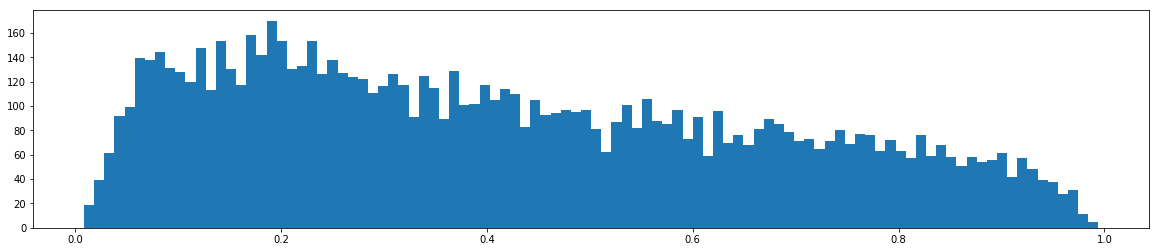

In [122]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [123]:
sub.to_csv('submissions/libfm_baseline_1.csv')